<h1 style="text-align:center">New York City Taxi Trip Duration</h1>

<h3 style="text-align:center">Load Libraries</h3>

In [1]:
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from bokeh.plotting import figure, show 
from bokeh.charts import Donut, show
from bokeh.io import output_notebook
output_notebook()


Loading BokehJS ...

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center">Load Dataset</h3>

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1458644, 11)
Test set shape: (625134, 9)


<h3 style="text-align:center">Data exploration</h3>

In [5]:
# Observation of the first 5 elements in the training set
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
# Check the types or each features
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Analyze missing data 

In [7]:
# print(train_df.isnull().sum(), "\n")
# print(test_df.isnull().sum())

pd.DataFrame( {'missing values(train set)': train_df.isnull().sum(),
              'missing values(test_set)' : test_df.isnull().sum() } )

,missing values(test_set),missing values(train set)
dropoff_datetime,NaN,0
dropoff_latitude,0.0,0
dropoff_longitude,0.0,0
id,0.0,0
passenger_count,0.0,0
pickup_datetime,0.0,0
pickup_latitude,0.0,0
pickup_longitude,0.0,0
store_and_fwd_flag,0.0,0
trip_duration,NaN,0


There's no missing data in both the train and test dataframe

<u>Target Feature</u>

In [8]:
# pd.options.display.float_format = '{:,.2f}'.format
train_df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Let's observe the skewness of the trip duration

In [9]:
train_df['trip_duration'].skew()

343.1639435917362

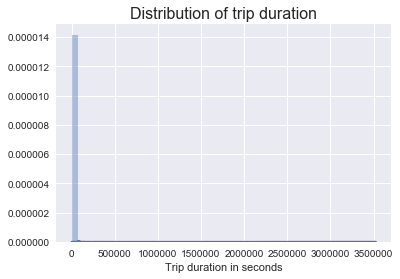

In [10]:
sns.distplot(train_df['trip_duration'])
plt.title("Distribution of trip duration", size=16)
plt.xlabel("Trip duration in seconds")
plt.show()

In regression problems, it is important to look for the skewness of the target feature. <br>
In fact, algorithms such as linear regression or K-Nearest Neighbors are sensitive to the skewness of the data. <br>
The most common correction for a positive skew is to apply <i>the Log transform</i> to have a normally distributed variable.

Skew is: -0.340704230448


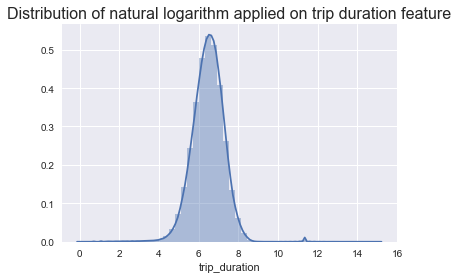

In [11]:
target = np.log(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.title("Distribution of natural logarithm applied on trip duration feature", size=16)
plt.show()

For the sake of meaningful visualization, we store the result in another variable so that we will be able to make use of it during the processing part.

<u>Correlation with trip duration</u>

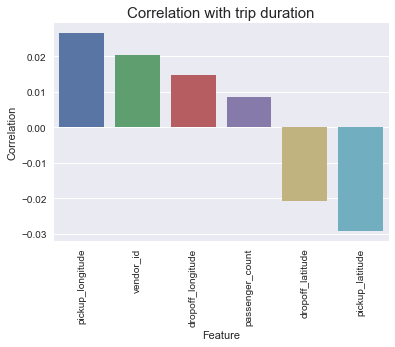

In [12]:
corr = train_df.drop(['id'], axis=1).corr()
corr_df = pd.DataFrame(corr['trip_duration'].sort_values(ascending=False))[1:]
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=90)
plt.title('Correlation with trip duration', size=15)
plt.show()

We observe that there is not strong relation with the trip duration and the actual numerical features. <br>
We need to feature engineering the string features to establish a new correlation plot as we might infer something more interesting.

<h3 style="text-align:center">Data Cleaning</h3>

In [13]:
pd.DataFrame( {'passenger_count (train set)': train_df['passenger_count'].value_counts(),
              'passenger_count (test_set)' : test_df['passenger_count'].value_counts()} )

,passenger_count (test_set),passenger_count (train set)
0,23.0,60
1,443447.0,1033540
2,90027.0,210318
3,25686.0,59896
4,12017.0,28404
5,33411.0,78088
6,20521.0,48333
7,NaN,3
8,NaN,1
9,2.0,1


We will treat values with 0 passenger_count to 1. <br>

In [14]:
def clean_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] == 0, 'passenger_count' ] = 1

clean_passenger_count(train_df)
clean_passenger_count(test_df)

In [15]:
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>Trip duration</u>

In [45]:
train_df.loc[ train_df['trip_duration'] > 80000, : ].shape

(1899, 16)

About 1900 trips accounted a trip duration of about 80000s, which is 1333hours that results in 55 days ! <br>
There is obviously an error and we have to filter this erroneous values.

In [31]:
train_df.loc[ train_df['trip_duration'] > 70000, : ]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayOfWeekNum,DayOfWeek,Month,DayOfMonth,HourOfDay
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,5,Saturday,2,20,4
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149,5,Saturday,5,7,18
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352,1,Tuesday,6,7,12
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236,5,Saturday,2,13,0
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197,4,Friday,3,18,11
4336,id3632390,2,2016-06-08 08:54:33,2016-06-09 07:58:09,5,-73.980560,40.742466,-73.984718,40.748611,N,83016,2,Wednesday,6,8,8
5104,id3354426,2,2016-05-05 15:18:41,2016-05-06 15:11:07,1,-73.989037,40.773514,-73.980682,40.781521,N,85946,3,Thursday,5,5,15
5778,id0773526,2,2016-04-02 14:58:45,2016-04-03 14:19:55,6,-73.987991,40.761341,-74.002922,40.756279,N,84070,5,Saturday,4,2,14
6132,id3617210,2,2016-03-15 17:51:32,2016-03-16 17:18:04,1,-73.965607,40.765781,-73.972649,40.753418,N,84392,1,Tuesday,3,15,17
6513,id0067152,2,2016-02-27 21:04:05,2016-02-28 21:03:22,5,-73.993744,40.727444,-74.001335,40.729244,N,86357,5,Saturday,2,27,21


<h3 style="text-align:center">Feature Engineering</h3>

In [18]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [19]:
# convert feature to datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S") 

# Extract weekday number (from Monday=0 to Sunday=6)
train_df['DayOfWeekNum'] = train_df['pickup_datetime'].dt.dayofweek

# Extract Day of week
train_df['DayOfWeek'] = train_df['pickup_datetime'].dt.weekday_name

# Extract Month 
train_df['Month'] = train_df['pickup_datetime'].dt.month

# Extract the Month's day from 0 to 31
train_df['DayOfMonth'] = train_df['pickup_datetime'].dt.day

# Extract the Hour of the day
train_df['HourOfDay'] = train_df['pickup_datetime'].dt.hour


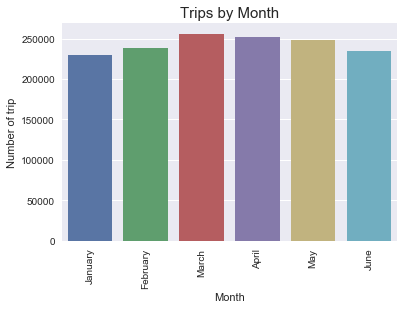

In [20]:
fig, ax = plt.subplots()

sns.countplot(x='Month', 
             data=train_df)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['January', 'February', 'March', 'April', 'May', 'June']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Month', size=15)
plt.ylabel('Number of trip')

plt.show()

Interestingly, the data provided only offers the trips of the first half of 2016. <br>
Furthermore, we observe that March was the most successful month in terms of number of trips. <br>
On the other hand January is not as successful, probably due to the fact that January is usually the coldest month of the year for New York.

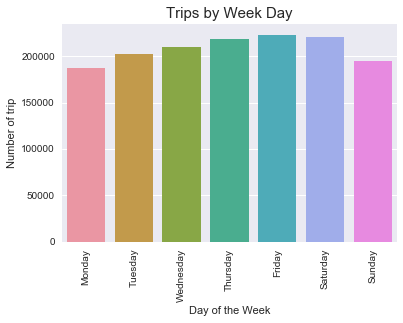

In [21]:
fig, ax = plt.subplots()

sns.countplot(x='DayOfWeekNum',
              data=train_df)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', \
         'Friday', 'Saturday', 'Sunday']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Week Day', size=15)
plt.xlabel('Day of the Week')
plt.ylabel('Number of trip')


plt.show()

This previous plot display how the traffic of taxis is doing during the weeks. <br>
Friday seems to be the most profitable day with Saturday while Sunday and Monday are the less demanding of taxis.

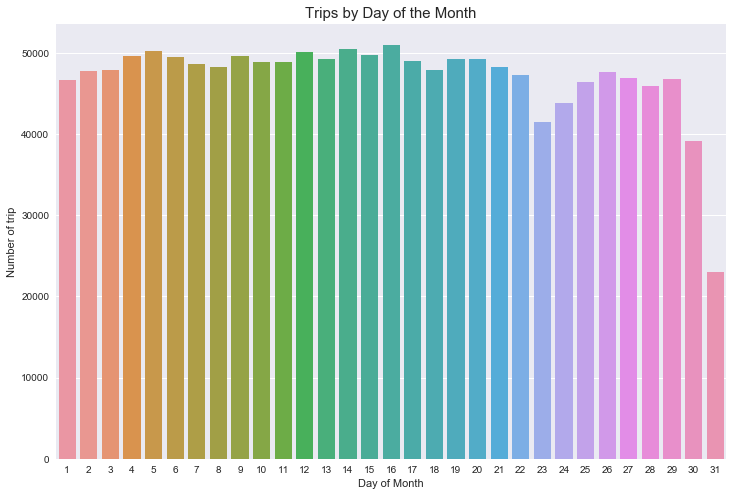

In [22]:
plt.figure(figsize=(12,8))

sns.countplot(x='DayOfMonth',
             data=train_df)

plt.title('Trips by Day of the Month', size=15)
plt.xlabel('Day of Month')
plt.ylabel('Number of trip')

plt.show()

The repartition is quite well distributed. <br>
One might notice that the 31st there is way less trips but that is due to the fact there is way less 31st number in the year. <br>
In 2016, only January, March and May had 31 days in the first half of the year. <br>
Days with 31 days also include day 30 so end of months are quite low regarding number of trips from taxis comparing to other days.

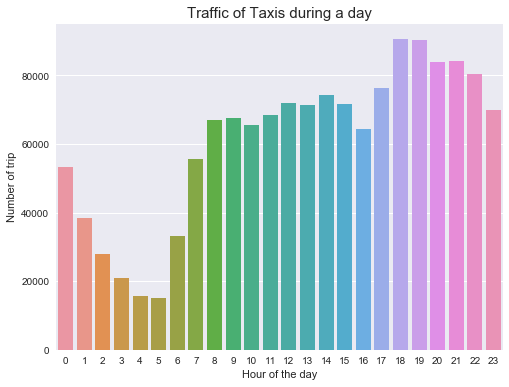

In [23]:
plt.figure(figsize=(8,6))

sns.countplot(x='HourOfDay',
           data=train_df)

plt.title('Traffic of Taxis during a day', size=15)
plt.xlabel('Hour of the day')
plt.ylabel('Number of trip')

plt.show()

Clearly from this plot we can infer that peak times are [6pm : 7pm] and off-peak times are [4am : 5pm].
From 6am the trend is growing up to 7pm. And past this hour, the trend is going the other way.

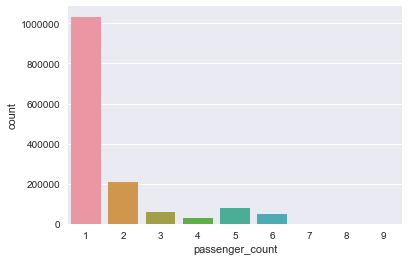

In [24]:
sns.countplot(train_df['passenger_count'])

<u>Passenger count</u>

In [47]:
train_df['passenger_count'].value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

We will group the number of passenger to be less sparse.

In [48]:
def transform_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] >= 3, 'passenger_count' ] = 3
    
transform_passenger_count(train_df)
transform_passenger_count(test_df)

# train_df.loc[ train_df['passenger_count'] >= 3, 'passenger_count' ] = 3

In [49]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>Distance in miles</u>

In [53]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayOfWeekNum,DayOfWeek,Month,DayOfMonth,HourOfDay
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,Monday,3,14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,Sunday,6,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,Tuesday,1,19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,Wednesday,4,6,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,Saturday,3,26,13


In [77]:
from geopy.distance import great_circle

# pick_up = (-73.982155, 40.767937)
# drop_off = (-73.964630,40.765602)

# pick_up  = (train_df['pickup_longitude'][0], train_df['pickup_latitude'][0])

# drop_off = (train_df['dropoff_longitude'][0], train_df['dropoff_latitude'][0])

def distance_calc(row):
    pickup  = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return great_circle(pickup, dropoff).km

def get_distance(dataset):
    dataset['distance'] = dataset.apply(lambda row: distance_calc(row), axis=1)
    dataset.drop(['pickup_latitude', 'pickup_longitude', \
                  'dropoff_latitude','dropoff_longitude'], 
                   axis=1,
                   inplace=True)
    
# train_df['distance'] = train_df.apply(lambda row: distance_calc(row), axis=1)

# get_distance(train_df)
get_distance(test_df)

In [78]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance
0,id3004672,1,2016-06-30 23:59:58,1,N,2.747200
1,id3505355,1,2016-06-30 23:59:53,1,N,2.760016
2,id1217141,1,2016-06-30 23:59:47,1,N,1.306523
3,id2150126,2,2016-06-30 23:59:41,1,N,5.270572
4,id1598245,1,2016-06-30 23:59:33,1,N,0.961113
